In [63]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [64]:
data = pd.read_csv('D:\\SimpliLearn\\Machine Learning\\Assisted Practice\\Lesson 7\\AirPassengers.csv')

In [65]:
data['Month'].head()

0    1949-01
1    1949-02
2    1949-03
3    1949-04
4    1949-05
Name: Month, dtype: object

In [66]:

data['Month'] = data['Month'].apply(lambda x: dt(int(x[:4]), int(x[5:]), 15))
data = data.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


In [67]:
ts = data['#Passengers']

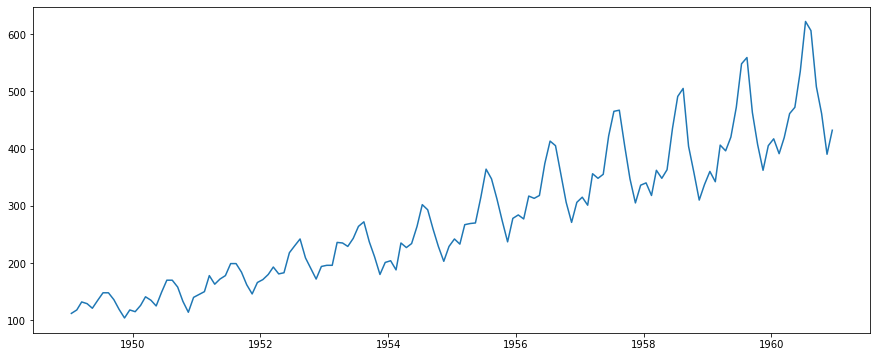

In [68]:
plt.plot(ts)

### We can observe seasonality and trend in the above graph

In [69]:
ts_log = np.log(ts)

In [70]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

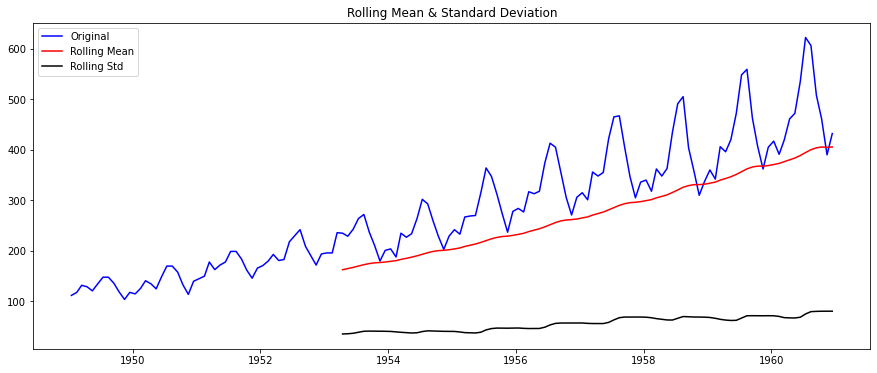

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [71]:
test_stationarity(data['#Passengers'])

### Time series is not stationary

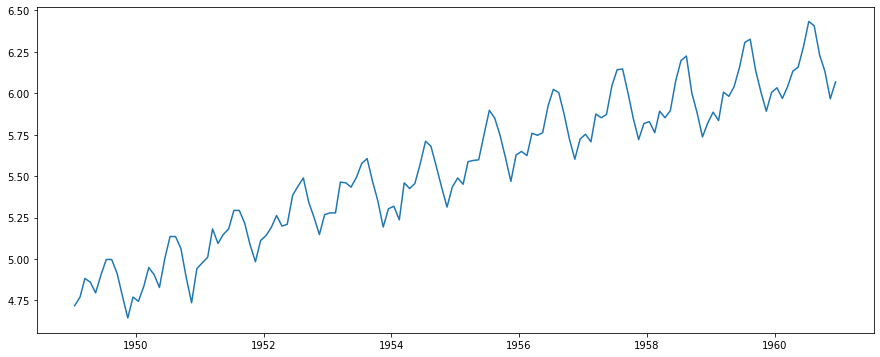

In [72]:
plt.plot(ts_log)

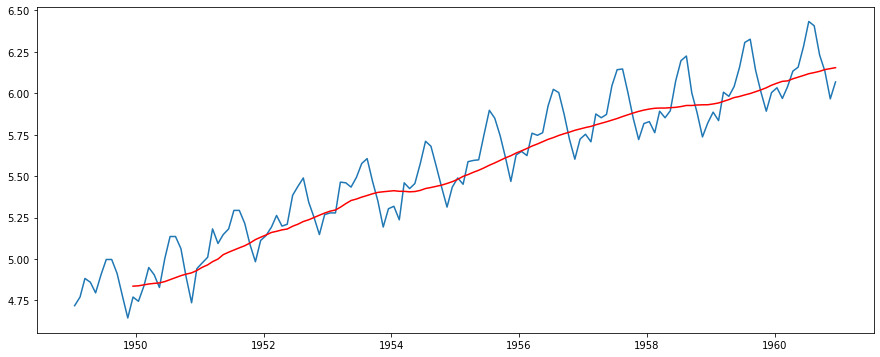

In [73]:
movingAverage = ts_log.rolling(window=12).mean()
movingSTD = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage, color='red')

In [74]:
# Get the difference between the moving average and the actual number of passengers
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)
#Remove Nan Values
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

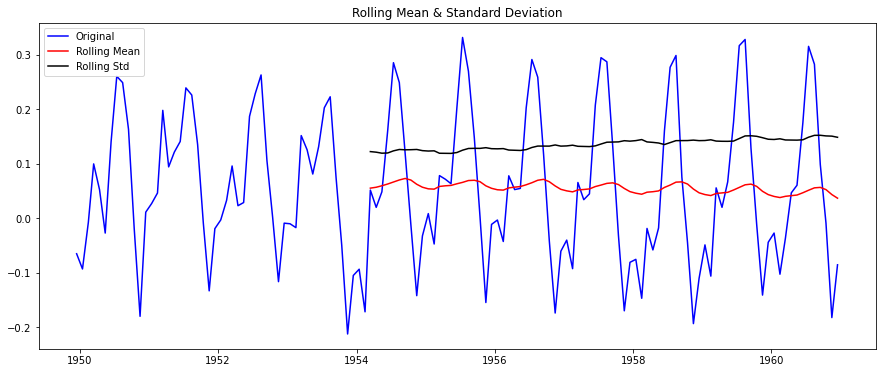

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [75]:
test_stationarity(ts_log_mv_diff)

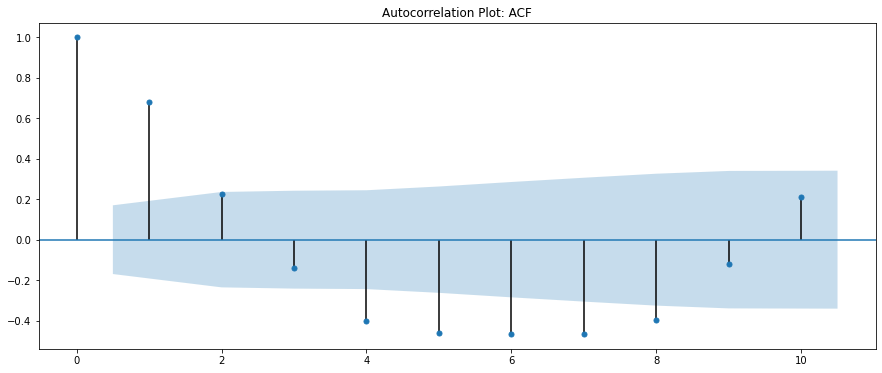

In [76]:
title = 'Autocorrelation Plot: ACF'
lags = 10
plot_acf(ts_log_mv_diff,title=title,lags=lags);

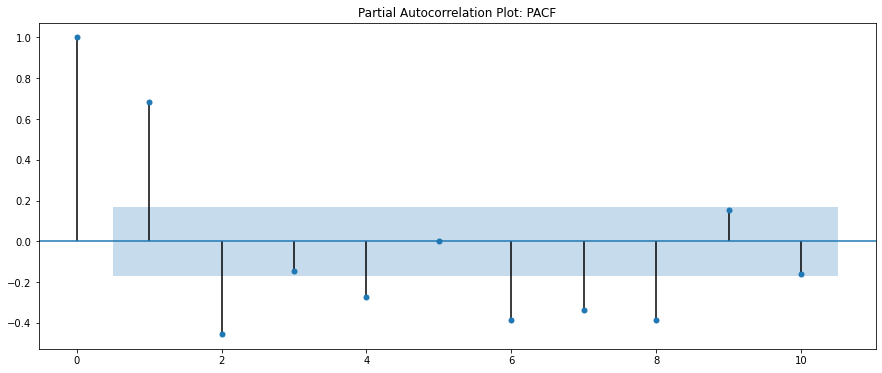

In [77]:
title = 'Partial Autocorrelation Plot: PACF'
lags = 10
plot_pacf(ts_log_mv_diff,title=title,lags=lags);

C:\Users\sarva\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\sarva\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


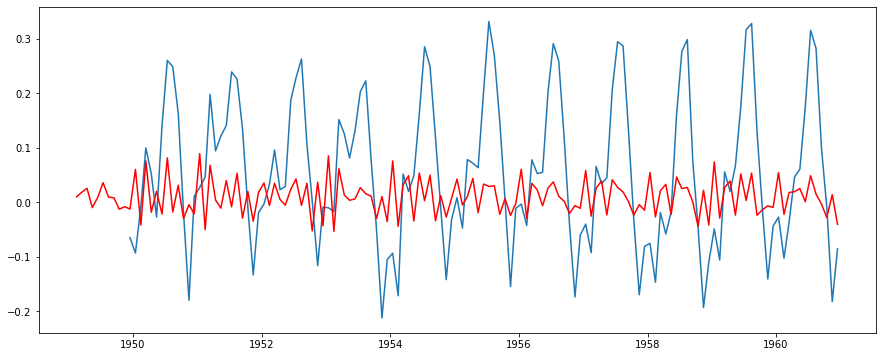

In [78]:
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')


In [79]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-15    0.009800
1949-03-15    0.017618
1949-04-15    0.025229
1949-05-15   -0.010225
1949-06-15    0.008528
dtype: float64

In [80]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-15    0.009800
1949-03-15    0.027418
1949-04-15    0.052647
1949-05-15    0.042422
1949-06-15    0.050950
dtype: float64

In [81]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.728299
1949-03-15    4.745917
1949-04-15    4.771146
1949-05-15    4.760921
dtype: float64

Text(0.5, 1.0, 'RMSE: 52.4890')

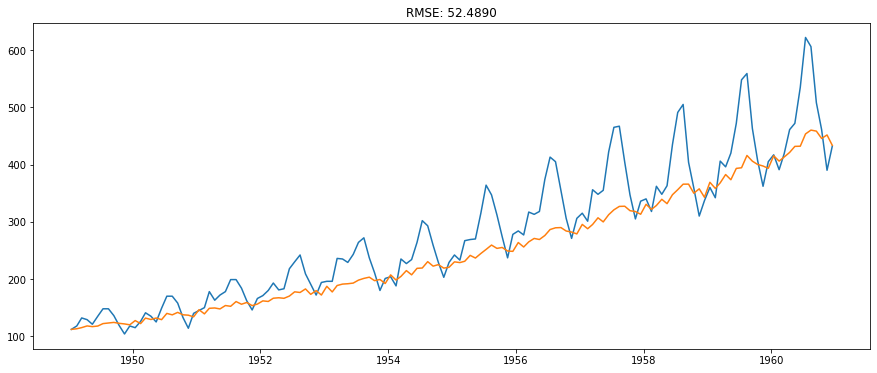

In [82]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [83]:
# model = ARIMA(data['#Passengers'],order=(1,1,1))
# results = model.fit()
fcast = results.predict(len(data),len(data)+11,typ='levels')

C:\Users\sarva\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\sarva\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\sarva\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\sarva\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an int

In [84]:
fcast

143    443.492873
144    452.676509
145    460.151308
146    466.361566
147    471.636062
148    476.218094
149    480.287702
150    483.978115
151    487.387925
152    490.590087
153    493.638590
154    496.573385
dtype: float64